In [ ]:
!pip install tokenizers==0.8.1.rc1
!pip install simpletransformers
!pip install wandb 
!pip install gcsfs
!pip install wordcloud
# conda install pytorch cudatoolkit=10.1 -c pytorch 

In [ ]:
%%bash
git clone -q https://github.com/NVIDIA/apex
cd apex
pip install -q -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

Processing /content/apex
Skipping wheel build for apex, due to binaries being disabled for it.
    Running setup.py install for apex: started
    Running setup.py install for apex: finished with status 'done'


/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)


In [ ]:
!wandb login 3cb3fe2145cb9672963a71138f205bc4c4aa61a4
!wandb on

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!
W&B enabled, running your script from this directory will now sync to the cloud.


In [ ]:
from google.colab import auth
auth.authenticate_user()
project_id = ["nimble-ally-283321"]
bucket_name = ["mgrdata2"]
!gcloud config set project {"nimble-ally-283321"}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



In [ ]:
from tqdm import tqdm
from tqdm import tqdm_notebook
from tqdm.auto import tqdm
tqdm.pandas()
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import logging
import re
from wordcloud import STOPWORDS


In [ ]:
import random
import os
def seed_everything(seed=1234):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)

In [ ]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
original_train = pd.read_csv('gs://mgrdata2/data/original_train.csv')

print("Number of data points in training data:", original_train.shape[0])
original_train.head()

Number of data points in training data: 1306122


qid  ... target
0  00002165364db923c7e6  ...      0
1  000032939017120e6e44  ...      0
2  0000412ca6e4628ce2cf  ...      0
3  000042bf85aa498cd78e  ...      0
4  0000455dfa3e01eae3af  ...      0

[5 rows x 3 columns]

In [ ]:
# Replacing math equations and url addresses with tags.
# https://www.kaggle.com/canming/ensemble-mean-iii-64-36
def clean_tag(text):
  global replaced_urls
  global replaced_math_formulas

  if '[math]' in text:
    text = re.sub('\[math\].*?math\]', '[formula]', text) #replacing with [formula]
    replaced_math_formulas+=1
    
  if 'http' in text or 'www' in text:
    text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', '[url]', text) #replacing with [url]
    replaced_urls+=1

  return text

In [ ]:
# list of symbols taken from https://www.kaggle.com/canming/ensemble-mean-iii-64-36
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞', 
        '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
        '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢','\n']
# removes punctuation
def clean_punct(x):
  x = str(x)
  for punct in puncts:
    if punct in x:
      x = x.replace(punct, ' ')
  return x

In [ ]:
# spelling correction by edits taken from https://www.kaggle.com/wowfattie/3rd-place
def words(text): return re.findall(r'\w+', text.lower())

def P(word):
  "Probability of `word`"
  # use inverse of rank as proxy
  # returns 0 if the word isn't in the dictionary
  return - WORDS.get(word, 0)

def correction(word):
  "Most probable spelling correction for word."
  return max(candidates(word), key=P)

def candidates(word):
  "Generate possible spelling corrections for word."
  return (known([word]) or known(edits1(word)) or [word])

def candidates2(word): 
  "Generate possible spelling corrections for word."
  return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words):
  "The subset of `words` that appear in the dictionary of WORDS."
  return set(w for w in words if w in WORDS)

def edits1(word):
  "All edits that are one edit away from `word`."
  letters = 'abcdefghijklmnopqrstuvwxyz'
  splits = [(word[:i], word[i:])        for i in range(len(word) + 1)]
  deletes = [L + R[1:]                  for L, R in splits if R]  
  transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]  
  replaces = [L + c + R[1:]             for L, R in splits if R for c in letters]
  inserts = [L + c + R                  for L, R in splits for c in letters]
  return set(deletes + transposes + replaces + inserts)

def edits2(word):
  "All edits that are two edits away from `word`"
  return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def singlify(word):
  return "".join([letter for i, letter in enumerate(word) if i == 0 or letter != word[i-1]])

In [ ]:
from nltk.tokenize.toktok import ToktokTokenizer
simple_tokenizer = ToktokTokenizer()

def correct_mispell(x):
  global misspelled_words_corrected
  words = simple_tokenizer.tokenize(x)
  words = [token.strip() for token in words]
  for i in range(0, len(words)):
    if words[i] in tokenizer.vocab:                           #return the same word when present in tokenizer vocab        
      words[i] = words[i]
      misspelled_words_corrected +=1
    elif words[i].lower() in tokenizer.vocab:                 #check if lowercased word present in tokenizer vocab
      words[i] = words[i].lower()
      misspelled_words_corrected +=1
    elif words[i].capitalize() in tokenizer.vocab:            #check if capitalized word present in tokenizer vocab
      words[i] = words[i].capitalize()
      misspelled_words_corrected +=1
    elif words[i].upper() in tokenizer.vocab:                 #check if uppercase word present in tokenizer vocab
      words[i] = words[i].upper()
      misspelled_words_corrected +=1
    elif correction(words[i]) != words[i]:                    #check if spelling correction  present in tokenizer vocab
      words[i] = correction(words[i])
      misspelled_words_corrected +=1
    elif correction(words[i].lower()) != words[i].lower():            #check if spelling correction  when lowered present in tokenizer vocab
      misspelled_words_corrected +=1
      words[i] = correction(words[i].lower())
    elif correction(words[i].capitalize()) != words[i].capitalize():       #check if spelling correction when capitalized present in tokenizer vocab
      misspelled_words_corrected +=1
      words[i] = correction(words[i].capitalize())            
    elif correction(words[i].upper()) != words[i].upper():            #check if spelling correction when upper present in tokenizer vocab
      misspelled_words_corrected +=1
      words[i] = correction(words[i].upper())
        
  words = " ".join(words)
  return words

In [ ]:
# remove stopwords
def remove_stopwords(x):
  x = [word for word in x.split() if word not in STOPWORDS]
  x = ' '.join(x)

  return x

In [ ]:

## taken from https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2 

contraction_mapping = {"We'd": "We had", "That'd": "That had", "AREN'T": "Are not", "HADN'T": "Had not", "Could've": "Could have", "LeT's": "Let us", "How'll": "How will", "They'll": "They will", "DOESN'T": "Does not", "HE'S": "He has", "O'Clock": "Of the clock", "Who'll": "Who will", "What'S": "What is", "Ain't": "Am not", "WEREN'T": "Were not", "Y'all": "You all", "Y'ALL": "You all", "Here's": "Here is", "It'd": "It had", "Should've": "Should have", "I'M": "I am", "ISN'T": "Is not", "Would've": "Would have", "He'll": "He will", "DON'T": "Do not", "She'd": "She had", "WOULDN'T": "Would not", "She'll": "She will", "IT's": "It is", "There'd": "There had", "It'll": "It will", "You'll": "You will", "He'd": "He had", "What'll": "What will", "Ma'am": "Madam", "CAN'T": "Can not", "THAT'S": "That is", "You've": "You have", "She's": "She is", "Weren't": "Were not", "They've": "They have", "Couldn't": "Could not", "When's": "When is", "Haven't": "Have not", "We'll": "We will", "That's": "That is", "We're": "We are", "They're": "They' are", "You'd": "You would", "How'd": "How did", "What're": "What are", "Hasn't": "Has not", "Wasn't": "Was not", "Won't": "Will not", "There's": "There is", "Didn't": "Did not", "Doesn't": "Does not", "You're": "You are", "He's": "He is", "SO's": "So is", "We've": "We have", "Who's": "Who is", "Wouldn't": "Would not", "Why's": "Why is", "WHO's": "Who is", "Let's": "Let us", "How's": "How is", "Can't": "Can not", "Where's": "Where is", "They'd": "They had", "Don't": "Do not", "Shouldn't":"Should not", "Aren't":"Are not", "ain't": "is not", "What's": "What is", "It's": "It is", "Isn't":"Is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
import nltk
nltk.download('wordnet')
def lemma_text(text):
    tokenizer = ToktokTokenizer()
    wordnet_lemmatizer = WordNetLemmatizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def data_cleaning_keep_symbols(x):
  x = clean_tag(x)
  x = clean_contractions(x)
  return x

In [ ]:
replaced_math_formulas = 0
replaced_urls = 0
misspelled_words_corrected = 0
def preprocess(function, dataset):
  global replaced_math_formulas
  global replaced_urls
  global misspelled_words_corrected
  replaced_math_formulas = 0
  replaced_urls = 0
  misspelled_words_corrected = 0
  print(f'Preprocessing with function {function}')
  dataset['preprocessed_question_text'] = dataset['question_text'].progress_map(lambda x: function(x))
  print(f'Replaced math formulas {replaced_math_formulas}')
  print(f'Replaced url formulas {replaced_urls}')
  print(f'Fixed spelling {misspelled_words_corrected}')

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
WORDS = tokenizer.vocab

print('Original: ', original_train['question_text'][0])
print('Tokenized: ', tokenizer.tokenize(original_train['question_text'][0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(original_train['question_text'][0])))


Original:  How did Quebec nationalists see their province as a nation in the 1960s?
Tokenized:  ['How', 'did', 'Quebec', 'nationalists', 'see', 'their', 'province', 'as', 'a', 'nation', 'in', 'the', '1960s', '?']
Token IDs:  [1731, 1225, 5181, 25170, 1267, 1147, 3199, 1112, 170, 3790, 1107, 1103, 3266, 136]


# Data cleaning with lemmatization

In [ ]:
preprocessing_function = data_cleaning_keep_symbols
preprocess(preprocessing_function, original_train)

Preprocessing with function <function data_cleaning_keep_symbols at 0x7f1e4f5709d8>



Replaced math formulas 735
Replaced url formulas 709
Fixed spelling 0


# Training model

In [ ]:
seed_everything()

In [ ]:
train_data = original_train.rename(columns={'preprocessed_question_text': 'text', 'target':'labels'})

In [ ]:
from sklearn.model_selection import StratifiedKFold
n=5
kf = StratifiedKFold(n_splits=n, random_state=123, shuffle=True)

In [ ]:
ksplit = kf.split(train_data, train_data['labels'])
k = 1
for _ in range(k):
    train_index, val_index = next(ksplit)

train_df = train_data.iloc[train_index]
val_df = train_data.iloc[val_index]

In [ ]:
model_type = 'bert'
model_name = 'bert-base-cased'
weighted = False
learning_rate = 1e-5
max_seq_len = 100
batch_size = 128

In [ ]:
fullname =f'{model_type}-{model_name}-fold{k}-b{batch_size}-{learning_rate}-weighted{weighted}-{preprocessing_function.__name__}'

In [ ]:
from time import time
import sklearn
from simpletransformers.classification import ClassificationModel

transformers_logger = logging.getLogger("simpletransformers")
transformers_logger.setLevel(logging.INFO)



model_args = {
              'max_seq_length': max_seq_len,
              'train_batch_size': batch_size,
              'eval_batch_size': batch_size,
              'gradient_accumulation_steps': 1,
              'learning_rate': learning_rate,
              'manual_seed': 1234,
              'num_train_epochs':3,
              'no_cache': False,
              'reprocess_input_data': True,  
              'overwrite_output_dir': True,
              'save_model_every_epoch': False,
              'save_eval_checkpoints' : False,
              'save_steps' : 0,
              'use_early_stopping':False,
              "early_stopping_metric_minimize": False,
              'early_stopping_metric': "f1",
              'early_stopping_consider_epochs': True,
              'evaluate_during_training': True,
              'evaluate_during_training_verbose': True,
              'evaluate_during_training_steps': 0,
              'logging_steps': 50,
              'fp16': True,
              'verbose':True,
              'wandb_project': 'quora',
              'wandb_kwargs': {'name': fullname},
              'silent': True
}
if weighted:
  model = ClassificationModel(model_type, model_name, num_labels=2, weight=class_weights, args=model_args)
else:
  model = ClassificationModel(model_type, model_name, num_labels=2, args=model_args)


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
t0 = time()
model.train_model(train_df, eval_df=val_df, verbose=True, f1=sklearn.metrics.f1_score,acc=sklearn.metrics.accuracy_score)
train_time = time() - t0
print("train time:  %s" % format_time(train_time))

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model:{'mcc': 0.6818208341102022, 'tp': 10949, 'tn': 240910, 'fp': 4153, 'fn': 5213, 'f1': 0.7004222108495394, 'acc': 0.9641458512776342, 'eval_loss': 0.0883433907249434}
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model:{'mcc': 0.690713775239

train time:  8:30:59


In [ ]:
import os
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

zip_filename = f'{fullname}-outputs.zip'
zipf = zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED)
zipdir('outputs', zipf)
zipf.close()

In [ ]:
!gsutil cp *outputs.zip 'gs://mgrdata/outputs/bert_params/'


Copying file://bert-bert-base-cased-fold1-b128-1e-05-weightedFalse-data_cleaning_keep_symbols-outputs.zip [Content-Type=application/zip]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

ResumableUploadAbortException: 403 s19901@pjwstk.edu.pl does not have storage.objects.create access to mgrdata/outputs/bert_params/bert-bert-base-cased-fold1-b128-1e-05-weightedFalse-d

In [ ]:
if weighted:
  best_model = ClassificationModel(model_type, "outputs/best_model", num_labels=2, weight=class_weights, args=model_args)
else:
  best_model = ClassificationModel(model_type, "outputs/best_model", num_labels=2, args=model_args)

In [ ]:
result, model_outpus, wrong_predictions = best_model.eval_model(eval_df=val_df, verbose=True, f1=sklearn.metrics.f1_score,acc=sklearn.metrics.accuracy_score)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
INFO:simpletransformers.classification.classification_model:{'mcc': 0.6907137752393214, 'tp': 11109, 'tn': 240992, 'fp': 4071, 'fn': 5053, 'f1': 0.7088890306936378, 'acc': 0.9650722557182505, 'eval_loss': 0.08728618081887232}


In [ ]:
predictions, prediction_outputs = best_model.predict(val_df['text'].tolist())

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [ ]:
from sklearn import metrics
f1score = metrics.f1_score(val_df['labels'].tolist(), predictions)
print(f1score)

0.7088890306936378


In [ ]:
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.metrics import f1_score, classification_report
from sklearn import metrics


In [ ]:
def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(5, 3))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.title('Confusion Matrix')
  plt.show()
  
  print(f"Correctly classified sincere questions: {round(cm[0][0]/(cm[0][0] + cm[0][1])*100, 2)}%")
  print(f"Correctly classified insincere questions: {round(cm[1][1]/(cm[1][0] + cm[1][1])*100, 2)}%")

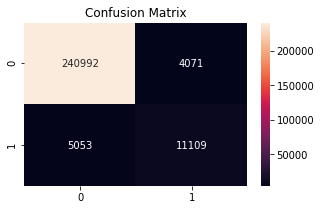

Correctly classified sincere questions: 98.34%
Correctly classified insincere questions: 68.74%


In [ ]:
import seaborn as sns
plot_confusion_matrix(val_df['labels'].tolist(), predictions)

In [ ]:
print(classification_report(val_df['labels'].tolist(), predictions))